# Homework 7 (50 points)

In this Homework, we will try to classify observations of space to be either stars, galaxies or quasars based on the RD14 from the Sloan Digital Sky Survey  (SDSS). The Sloan Digital Sky Survey is a project which offers public data of space observations. Observations have been made since 1998 and have been made accessible to everyone who is interested. 

http://www.sdss.org/
![alt text](http://www.fingerprintdigitalmedia.com/wp-content/uploads/2014/08/sdss1.jpg)

For this purpose a special 2.5 m diameter telescope was built at the Apache Point Observatory in New Mexico, USA. The telescope uses a camera of 30 CCD-Chips with 2048x2048 image points each. The chips are ordered in 5 rows with 6 chips in each row. Each row observes the space through different optical filters (u, g, r, i, z) at wavelengths of approximately 354, 476, 628, 769, 925 nm.


In this homework we will train several classifier to predict the class of a celestial object based on the observations (features). We will practice data prep, dimensionality reduction, model design and training, model comparison, and feature importance selection.

### Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# from matplotlib import style
# sns.set_style('whitegrid')
# import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
# from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import time 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline



## 1) Data Preparation (20 points)

We follow the following steps:
* read (1 point)
* clean (3 points)
* correlate (4 points)
* explore, spread of values (3 points)
* dimensionality reduction (9 points)

### 1.1 Data read
Read the pandas fata frame from the csv file "Skyserver_SQL2_27_2018.csv" and skip the first row.

**Task: read (1 point)**

Save a copy of the data frame just in case.

In [2]:
sdss_df = pd.read_csv('Skyserver_SQL2_27_2018.csv', skiprows=0)

**Description of the data fields**

* objid = Object Identifier, self explanatory.
* ra = J2000 Right Ascension (r-band). Angular that is measured eastward along the celestial equator from the Sun at the March equinox to the hour circle of the point above the earth in question.   https://en.wikipedia.org/wiki/Right_ascension
* dec = J2000 Declination (r-band). Angle that is measured north or south of the celestial equator, along the hour circle passing through the point in question. https://en.wikipedia.org/wiki/Declination



The Gunn astronomic magnitude system. u, g, r, i, z represent the response of the 5 bands of the telescope.

Further Information: http://astroweb.case.edu/ssm/ASTR620/mags.html 
* u = better of DeV/Exp magnitude fit
* g = better of DeV/Exp magnitude fit
* r = better of DeV/Exp magnitude fit
* i = better of DeV/Exp magnitude fit
* z = better of DeV/Exp magnitude fit




Run, rerun, camcol and field are features which describe a field within an image taken by the SDSS. A field is basically a part of the entire image corresponding to 2048 by 1489 pixels. 
* run = Run Number, which identifies the specific scan. 
* rereun = Rerun Number, which specifies how the image was processed.
* camcol = Camera column, a number from 1 to 6, identifying the scanline within the run.
* field = Field number, which typically starts at 11 (after an initial rampup time), and can be as large as 800 for particularly long runs.
* specobjid = Object Identifier
* class = object class (galaxy, star or quasar object): The class identifies an object to be either a galaxy, star or quasar. This will be the response variable which we will be trying to predict.

* redshift = Final Redshift: In physics, **redshift** happens when light or other electromagnetic radiation from an object is increased in wavelength, or shifted to the red end of the spectrum. 

* plate = plate number: Each spectroscopic exposure employs a large, thin, circular metal **plate** that positions optical fibers via holes drilled at the locations of the images in the telescope focal plane. These fibers then feed into the spectrographs. Each plate has a unique serial number, which is called plate in views such as SpecObj in the CAS.

* mjd = MJD of observation, **Modified Julian Date**, used to indicate the date that a given piece of SDSS data (image or spectrum) was taken.
* fiberid = fiber ID. The SDSS spectrograph uses optical fibers to direct the light at the focal plane from individual objects to the slithead. Each object is assigned a corresponding **fiberID**. 

**Further information on SDSS images and their attributes:** 

http://www.sdss3.org/dr9/imaging/imaging_basics.php

http://www.sdss3.org/dr8/glossary.php

### 1.2 Data Cleaning 

Basic stats about our dataset. 

**Task: Provide basic infor for the pandas dataframe head (0.5 point)**

In [3]:
# head
sdss_df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1.237650e+18,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,752,301,4,267,3.722360e+18,STAR,-0.000009,3306,54922,491
1,1.237650e+18,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,752,301,4,267,3.638140e+17,STAR,-0.000055,323,51615,541
2,1.237650e+18,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,752,301,4,268,3.232740e+17,GALAXY,0.123111,287,52023,513
3,1.237650e+18,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,752,301,4,269,3.722370e+18,STAR,-0.000111,3306,54922,510
4,1.237650e+18,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,752,301,4,269,3.722370e+18,STAR,0.000590,3306,54922,512


**Task: Find the data types of the database (floats, string, etc etc) using the ``info()`` function (0.5 point).**

In [4]:
# information
sdss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


Are there any obvious feature (or element of the dataframe) that should not impact our prediction?
 
**objid** and **specobjid** are just identifiers for accessing the rows back when they were stored in the original databank. Therefore we will not need them for classification as they are not related to the outcome.
The features **run**, **rerun**, **camcol** and **field** are values which describe parts of the camera at the moment when making the observation, e.g. 'run' represents the corresponding scan which captured the oject.

Source: http://www.sdss3.org/dr9/imaging/imaging_basics.php

**Task: Drop these columns in the pandas dataframe. (1 point)**

In [5]:
# answer
sdss_df.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid'], axis=1, inplace=True)
sdss_df.head(1)

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid
0,183.531326,0.089693,19.47406,17.0424,15.94699,15.50342,15.22531,STAR,-0.000009,3306,54922,491


Find our how many examples there are, how many attributes or feature, and the type of class.

In [6]:
# description
sdss_df.describe()

,ra,dec,u,g,r,i,z,redshift,plate,mjd,fiberid
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,175.529987,14.836148,18.619355,17.371931,16.840963,16.583579,16.422833,0.143726,1460.986400,52943.533300,353.069400
std,47.783439,25.212207,0.828656,0.945457,1.067764,1.141805,1.203188,0.388774,1788.778371,1511.150651,206.298149
min,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,-0.004136,266.000000,51578.000000,1.000000
25%,157.370946,-0.539035,18.178035,16.815100,16.173333,15.853705,15.618285,0.000081,301.000000,51900.000000,186.750000
50%,180.394514,0.404166,18.853095,17.495135,16.858770,16.554985,16.389945,0.042591,441.000000,51997.000000,351.000000
75%,201.547279,35.649397,19.259232,18.010145,17.512675,17.258550,17.141447,0.092579,2559.000000,54468.000000,510.000000
max,260.884382,68.542265,19.599900,19.918970,24.802040,28.179630,22.833060,5.353854,8410.000000,57481.000000,1000.000000


**Task: How many objects are in each class? (1 point)**

In [7]:
# Count the elements in each class
sdss_df['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

The classes are "GALAXY", "STAR", and "QSO" (quasars). They are defined as strings, but we will convert them to integer in order to apply a loss function on the class labels during training. For this, we use the ``sklearn.preprocessing.LabelEncoder()`` function. We will do so and modify the classes in the dataframe. We should keep a copy of the original data frame to be safe.

In [8]:
sdss_df_save = sdss_df # make a copy of the original data before cleaning it. That works well when the data is small.


### 1.3 Data correlations
Now let's find the most basic correlations among features. This can be done using the ``corr()`` function to apply on the pandas dataframe. Evaluate this function and comment on what feature is correlated among others. It is convenient to use the matplotlib function ``matshow()`` for clarity. ``seaborn`` is a python module that makes really pretty statistical plots https://seaborn.pydata.org/index.html#. Install it with ``pip`` and import it.

In [9]:
!pip install seaborn
import seaborn as sns

**Task: Plot the correlation matrix that can be called in the pandas dataframe. (2 points)**

Hints:

Use functions of ``heatmap``, add the labels in the axes. The colormap ``coolwarm`` is nice for divergent scales like correlations that vary between -1 and 1. The argument ``center=0`` ensures that the colormap is divergent from zero. Make sure to ignore the label column "class". Remember that dropping a column can be done in place ``sdss_df.drop('class', axis=1)``.

<AxesSubplot:>

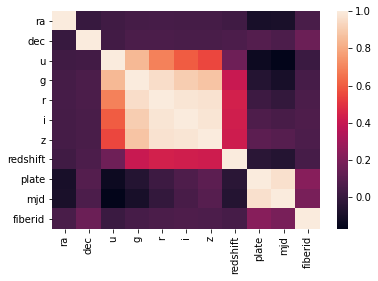

In [10]:
# answer
sns.heatmap(sdss_df.corr())

**Task: Reproduce the same plot for each of the three classes. (1 point)**
You can select the values from the pandas dataframe by selecting over the column 'class'. 

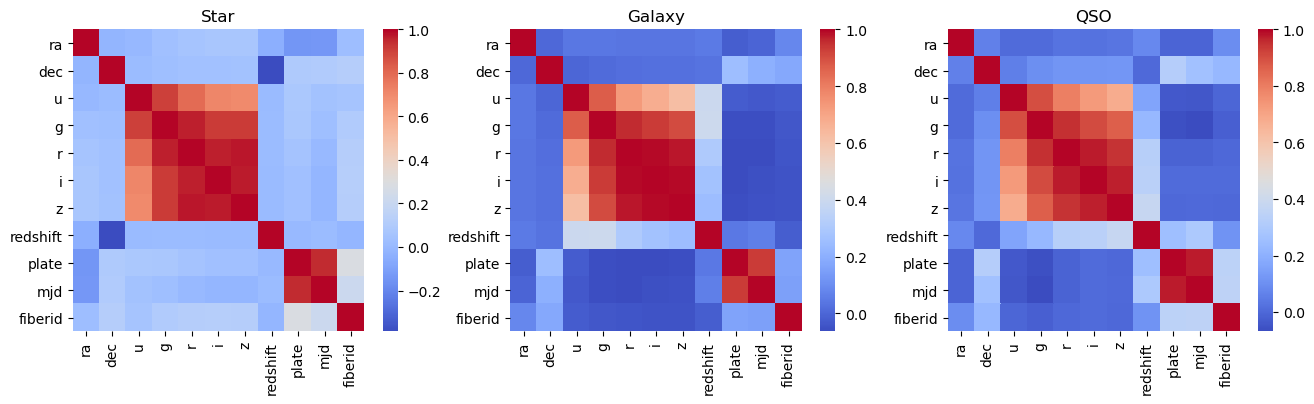

In [11]:
# make the same plot for Galaxies
# "GALAXY" is label 0

# Make the same plot for Stars (label 1)

# make the same plots for quasars (label 2)

import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
fig.set_dpi(100)
ax = sns.heatmap(sdss_df[sdss_df['class']=='STAR'].corr(), ax = axes[0], cmap='coolwarm')
ax.set_title('Star')
ax = sns.heatmap(sdss_df[sdss_df['class']=='GALAXY'].corr(), ax = axes[1], cmap='coolwarm')
ax.set_title('Galaxy')
ax = sns.heatmap(sdss_df[sdss_df['class']=='QSO'].corr(), ax = axes[2], cmap='coolwarm')
ax = ax.set_title('QSO')

**Task: Can you comment on groups of observations that can be grouped together or that appear independent from each other given these correlations, and if there is any difference between the three celestial objects? (**1 point**)**

### 1.5 Data exploration
Given the structure of the correlations, we will explore the values of the data.

#### 1.5.a. Distributions of redshift
"redshifting" happens when the source of light is becoming more distant to the receiver: the object is moving away from Earth. 

**Task: plot histograms for the 'redshift' feature column for each class (1 point).**

/Users/earthnote/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


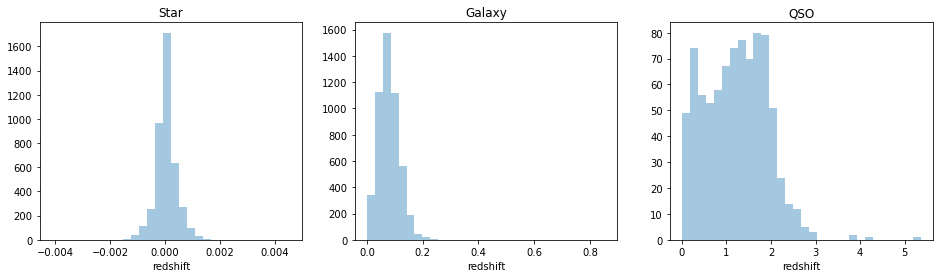

In [12]:
# answer
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(sdss_df[sdss_df['class']=='STAR'].redshift, bins = 30, ax = axes[0], kde = False)
ax.set_title('Star')
ax = sns.distplot(sdss_df[sdss_df['class']=='GALAXY'].redshift, bins = 30, ax = axes[1], kde = False)
ax.set_title('Galaxy')
ax = sns.distplot(sdss_df[sdss_df['class']=='QSO'].redshift, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('QSO')

**Task : Describe briefly the difference between the three histograms. (0.5 point)**

<!-- # answer -->
* **Star:** The histogram looks like a truncated zero-centered normal distribution. It looks like stars are both coming toward and away from the Earth.

* **Galaxy:** The redshift values may come from a slightly right-shifted normal distribution which is centered around 0.075. It looks like galaxies are moving away from the Earth but at slow speeds.

* **QSO:** The redshift values for QSOs are a lot more uniformly distributed than for Stars or Galaxies. They are roughly evenly distributed from 0 to 3, than the occurences decrease drastically. For 4 oder ~5.5 there are some outliers. This probably means that quasards are moving away from the earth with a diverse range of speeds.


#### 1.5.b. Right ascension (ra) and declination (dec) 

We will now plot the right ascension versus the declination depending on the class. You can use the ``lmplot`` function in ``seaborn`` (https://seaborn.pydata.org/generated/seaborn.lmplot.html) to represent the sky view of these objects.

/Users/earthnote/opt/anaconda3/lib/python3.8/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Equatorial coordinates')

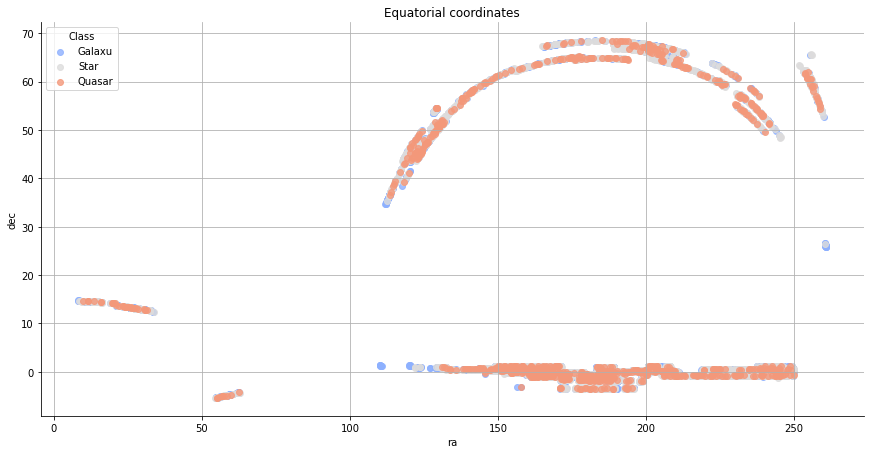

In [13]:
sns.lmplot(x='ra', y='dec', data=sdss_df, hue='class', fit_reg=False, palette='coolwarm', size = 6, aspect=2,legend=False)
plt.legend(title='Class', loc='upper left', labels=['Galaxu', 'Star','Quasar'])
plt.grid(True)
plt.title('Equatorial coordinates')

**Task: do you see any obvious differences such that one could easily discriminate between the two coordinates? (0.5 point)**

the equatorial coordinates do not differ significantly between the 3 classes. All SDSS images cover the same area of the sky. Because stars, galaxies and quasars are observed equally at all coordinates within this area, they cannot be discriminated from one another using just the spatial distribution

#### 1.5.c Filters - u,g,r,i,z 

Recall: u, g, r, i, z represent the different wavelengths which are used to capture the observations. According to the correlation matrix, they are correlated for all three classes.

Therefore it is interesting to see that band 'u' is less correlated to the other bands. 

**Task Plot histograms and discuss why you expect these features to be correlated (1 points)**

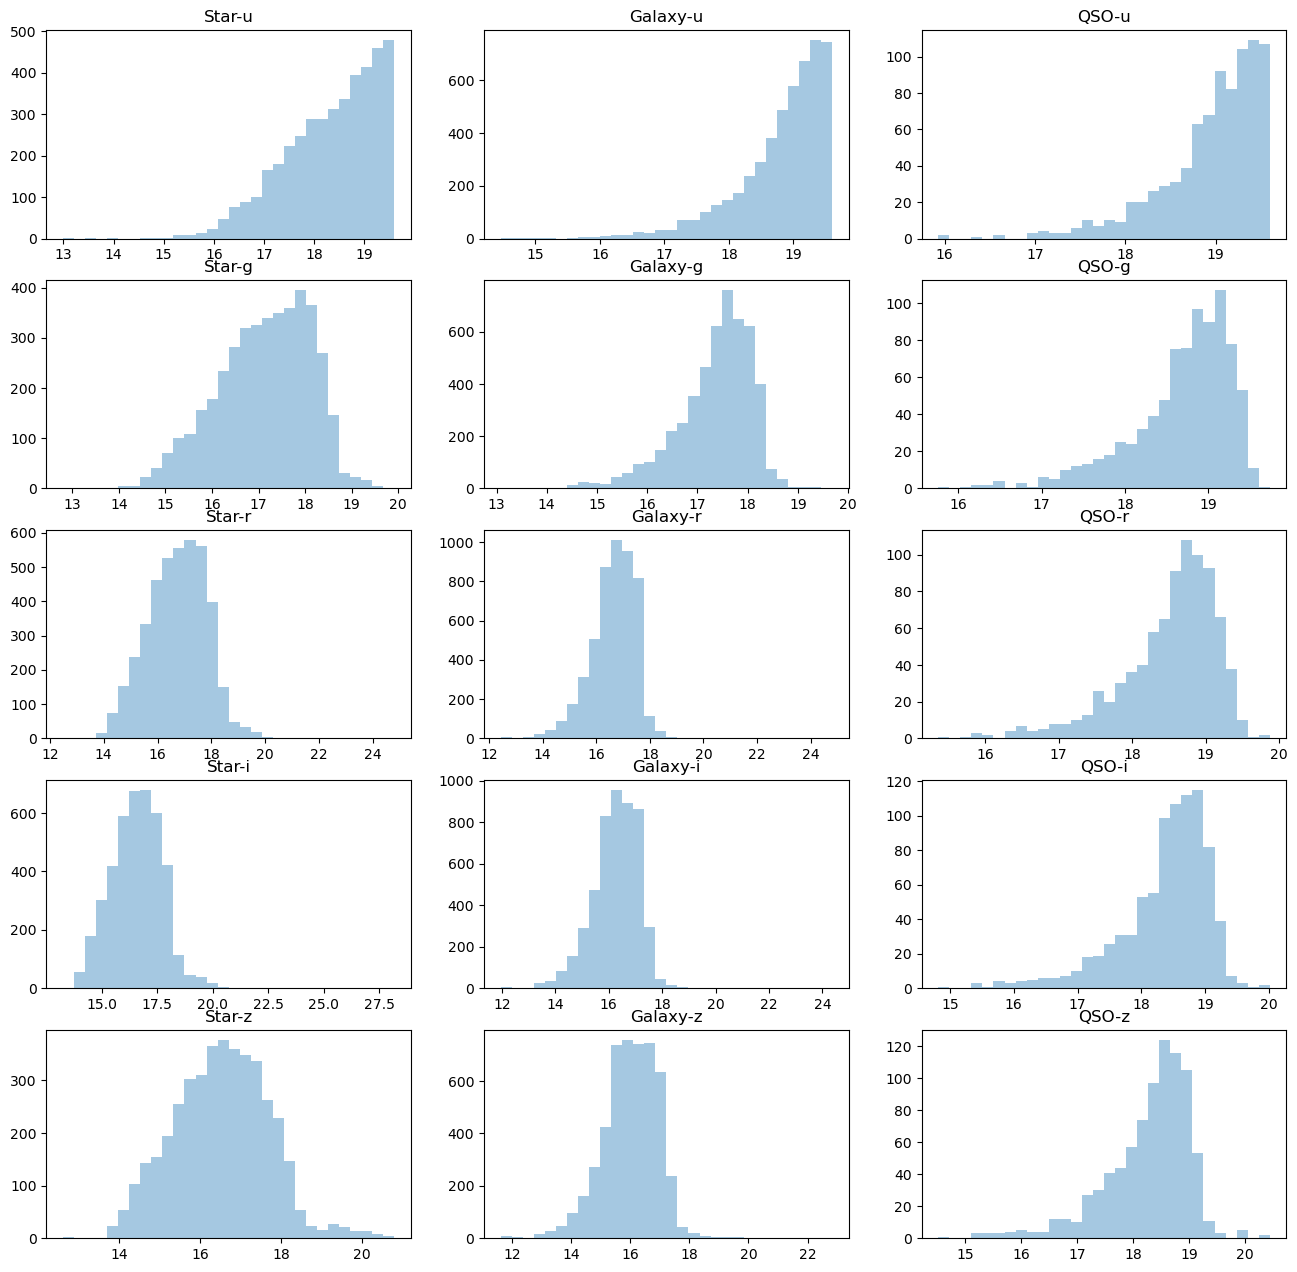

In [14]:
# Plot of histograms
import warnings
warnings.filterwarnings('ignore')

fig, axes = plt.subplots(nrows=5, ncols=3,figsize=(16, 16))
fig.set_dpi(100)
ax = sns.distplot(sdss_df[sdss_df['class']=='STAR'][['u']], bins = 30, ax = axes[0][0], kde = False)
ax.set_title('Star-u')
ax = sns.distplot(sdss_df[sdss_df['class']=='GALAXY'][['u']], bins = 30, ax = axes[0][1], kde = False)
ax.set_title('Galaxy-u')
ax = sns.distplot(sdss_df[sdss_df['class']=='QSO'][['u']], bins = 30, ax = axes[0][2], kde = False)
ax = ax.set_title('QSO-u')
ax = sns.distplot(sdss_df[sdss_df['class']=='STAR'][['g']], bins = 30, ax = axes[1][0], kde = False)
ax.set_title('Star-g')
ax = sns.distplot(sdss_df[sdss_df['class']=='GALAXY'][['g']], bins = 30, ax = axes[1][1], kde = False)
ax.set_title('Galaxy-g')
ax = sns.distplot(sdss_df[sdss_df['class']=='QSO'][['g']], bins = 30, ax = axes[1][2], kde = False)
ax = ax.set_title('QSO-g')
ax = sns.distplot(sdss_df[sdss_df['class']=='STAR'][['r']], bins = 30, ax = axes[2][0], kde = False)
ax.set_title('Star-r')
ax = sns.distplot(sdss_df[sdss_df['class']=='GALAXY'][['r']], bins = 30, ax = axes[2][1], kde = False)
ax.set_title('Galaxy-r')
ax = sns.distplot(sdss_df[sdss_df['class']=='QSO'][['r']], bins = 30, ax = axes[2][2], kde = False)
ax = ax.set_title('QSO-r')
ax = sns.distplot(sdss_df[sdss_df['class']=='STAR'][['i']], bins = 30, ax = axes[3][0], kde = False)
ax.set_title('Star-i')
ax = sns.distplot(sdss_df[sdss_df['class']=='GALAXY'][['i']], bins = 30, ax = axes[3][1], kde = False)
ax.set_title('Galaxy-i')
ax = sns.distplot(sdss_df[sdss_df['class']=='QSO'][['i']], bins = 30, ax = axes[3][2], kde = False)
ax = ax.set_title('QSO-i')
ax = sns.distplot(sdss_df[sdss_df['class']=='STAR'][['z']], bins = 30, ax = axes[4][0], kde = False)
ax.set_title('Star-z')
ax = sns.distplot(sdss_df[sdss_df['class']=='GALAXY'][['z']], bins = 30, ax = axes[4][1], kde = False)
ax.set_title('Galaxy-z')
ax = sns.distplot(sdss_df[sdss_df['class']=='QSO'][['z']], bins = 30, ax = axes[4][2], kde = False)
ax = ax.set_title('QSO-z')


<!-- Anwer: -->

### 1.6 Data Dimensionality Reduction
At this point, we are left with 8 features: redshift, u, g, r, i, z, ra, and dec. Among these, the filters (u, g, r, i, z) are correlated to each other. There is therefore a potential for reducing the dimensions of the features using PCA on these 5 features.

We will use the skilearn function ``sklearn.decomposition.PCA()`` to fit and transform the data into the PC coordinates. Lets' first explore how many PCs we need. Fit the PCA function over the total number of filters. You will fit the PCA function over an array with the columns selected from the dataframe. 

**Task: Perform the PCA over a max number of PCs, output the explained variance ratio values, decide on an appropriate maximum number of PC to use (6 points)**

In [15]:
sdss_df_fe = sdss_df

# encode class labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(sdss_df_fe['class'])
sdss_df_fe['class'] = y_encoded
sdss_df_fe

,ra,dec,u,g,r,i,z,class,redshift,plate,mjd,fiberid
0,183.531326,0.089693,19.47406,17.04240,15.94699,15.50342,15.22531,2,-0.000009,3306,54922,491
1,183.598371,0.135285,18.66280,17.21449,16.67637,16.48922,16.39150,2,-0.000055,323,51615,541
2,183.680207,0.126185,19.38298,18.19169,17.47428,17.08732,16.80125,0,0.123111,287,52023,513
3,183.870529,0.049911,17.76536,16.60272,16.16116,15.98233,15.90438,2,-0.000111,3306,54922,510
4,183.883288,0.102557,17.55025,16.26342,16.43869,16.55492,16.61326,2,0.000590,3306,54922,512
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,131.316413,51.539547,18.81777,17.47053,16.91508,16.68305,16.50570,0,0.027583,447,51877,246
9996,131.306083,51.671341,18.27255,17.43849,17.07692,16.71661,16.69897,0,0.117772,447,51877,228
9997,131.552562,51.666986,18.75818,17.77784,17.51872,17.43302,17.42048,2,-0.000402,7303,57013,622
9998,131.477151,51.753068,18.88287,17.91068,17.53152,17.36284,17.13988,0,0.014019,447,51877,229


*Answer on how many PCs to use*



We will now re-perform PCA with the number of PCs you found is most appropriate. Re-apply the fit-transform function. Update the dataframe by adding the PCA value(s) and dropping the columns of the 5 filter features.

**Task: PCA again, fit and transform, update the dataframe with the new feature(s) (3 points)**

In [16]:
# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(sdss_df_fe[['u', 'g', 'r', 'i', 'z']])

In [17]:
# update dataframe 
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
sdss_df_fe.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
sdss_df_fe.head()

,ra,dec,class,redshift,plate,mjd,fiberid,PCA_1,PCA_2,PCA_3
0,183.531326,0.089693,2,-0.000009,3306,54922,491,-1.507202,-1.377293,-0.265119
1,183.598371,0.135285,2,-0.000055,323,51615,541,-0.195758,-0.028410,-0.155695
2,183.680207,0.126185,0,0.123111,287,52023,513,1.297604,-0.590023,0.140338
3,183.870529,0.049911,2,-0.000111,3306,54922,510,-1.446117,0.566685,-0.009272
4,183.883288,0.102557,2,0.000590,3306,54922,512,-0.849271,1.287505,-0.397689


## 2) Machine Learning Models (26 points)

We will now train different models on this dataset. We have a total of 8 features, 3 classes, and 10,000 samples. We will use K-Nearest Neighbors, Naive Bayes, Random Forest, Support Vector Machine, Multi Layer Perceptron.

We now follow a normal machine learning workflow:
* Feature scaling (2 points)
* Train/test set split (2 points)
* Model design, training, testing (15 points)
* Model comparisons, pick your winner, discuss feature importance using Random Forest. (10 points)

### 2.1 Feature Scaling
Scaling all values to be within the (0, 1) interval will reduce the distortion due to exceptionally high values and make some algorithms converge faster. You can scale the features only by dropping the "class" column without modifying the dataframe in place, using the pandas function ``drop()``.

**Task: Scale just the features (2 points)**

In [18]:
scaler = MinMaxScaler()
sdss = scaler.fit_transform(sdss_df_fe.drop('class', axis=1))
print(sdss_df_fe)
print(pd.DataFrame(sdss))

              ra        dec  class  redshift  plate    mjd  fiberid     PCA_1  \
0     183.531326   0.089693      2 -0.000009   3306  54922      491 -1.507202   
1     183.598371   0.135285      2 -0.000055    323  51615      541 -0.195758   
2     183.680207   0.126185      0  0.123111    287  52023      513  1.297604   
3     183.870529   0.049911      2 -0.000111   3306  54922      510 -1.446117   
4     183.883288   0.102557      2  0.000590   3306  54922      512 -0.849271   
...          ...        ...    ...       ...    ...    ...      ...       ...   
9995  131.316413  51.539547      0  0.027583    447  51877      246  0.222959   
9996  131.306083  51.671341      0  0.117772    447  51877      228  0.259171   
9997  131.552562  51.666986      2 -0.000402   7303  57013      622  1.480725   
9998  131.477151  51.753068      0  0.014019    447  51877      229  1.392088   
9999  131.665012  51.805307      0  0.118417    447  51877      233 -0.936205   

         PCA_2     PCA_3  


### 2.2 Test, train, validation data sets.
**Task: Split the data into a training and a test part.  (2 points)**

The models will be trained on the training data set and tested on the test data set

In [19]:
X_train, X_test, y_train, y_test = train_test_split(sdss, sdss_df_fe['class'], test_size=0.33)


In [20]:
print(pd.DataFrame(X_train))

             0         1         2         3         4         5         6  \
0     0.480147  0.755906  0.025207  0.021979  0.049975  0.171171  0.512638   
1     0.718943  0.073995  0.000736  0.322814  0.506353  0.595596  0.222670   
2     0.774980  0.089665  0.028039  0.032171  0.075216  0.126126  0.477517   
3     0.012107  0.269474  0.000733  0.351916  0.536676  0.157157  0.311908   
4     0.940984  0.083480  0.000805  0.012033  0.071489  0.373373  0.565289   
...        ...       ...       ...       ...       ...       ...       ...   
6695  0.867158  0.913468  0.008099  0.042362  0.080806  0.607608  0.407578   
6696  0.839565  0.062642  0.015705  0.005034  0.014399  0.018018  0.523059   
6697  0.683849  0.049228  0.018654  0.007981  0.133830  0.589590  0.441642   
6698  0.605033  0.082040  0.248974  0.001105  0.056243  0.436436  0.644901   
6699  0.839999  0.898832  0.327703  0.041994  0.085211  0.400400  0.643594   

             7         8  
0     0.133881  0.501011  
1     0.2

Computation time is important to account for when scaling up the data set and the model size. You can evaluate the relative computational time using the function ``time.perf_counter()`` to evaluate the absolute time. Then compare the computational time by making the difference between two time stamps:

``t1=time.perf_counter()``

``t2=time.perf_counter()``

``tcomp = t2 - t1``

We will also assess the model performance of these multi-class classifiers. We will evaluate the average of the scores over the 3 class labels.

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_predict
label_name = ['Star','Galaxy','Quasar']

In the following, we will be testing over several classifiers. Follow the steps:
1. model definition/design
2. training
3. prediction on test
4. evaluation: a) print the classification_report; b) save the precision, recall, fscore and accuracy in variables

### 2.3.a K Nearest Neighbors (3 points)
Check out the function arguments and definition here: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [22]:
#answer
from sklearn.neighbors import KNeighborsClassifier
print("Classifying using K-nearest Neighbors")

# model design
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
preds = knn.predict(X_test)

acc_knn = (preds == y_test).sum().astype(float) / len(preds)*100
pres_knn= precision_score(y_test, preds, average='micro')
rec_knn=recall_score(y_test, preds, average='micro')
f1_knn=f1_score(y_test, preds, average='micro')
print("Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: %3.2f" % (acc_knn))
print("Precision:", precision_score(y_test, preds, average='micro'))
print("Recall:",recall_score(y_test, preds, average='micro'))
print("F1-Score:", f1_score(y_test, preds, average='micro'))


Classifying using K-nearest Neighbors
Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: 92.73
Precision: 0.9272727272727272
Recall: 0.9272727272727272
F1-Score: 0.9272727272727272


### 2.3.b Naive Bayes (3 points)
Check out the sklearn tutorial pages here: https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes. We propose to use the Gaussian Naive Bayes.

Naive Bayes assumes the data to be normally distributed which can be achieved by scaling using the MaxAbsScaler. For this example then we will use the unscaled data, then rescale it.

In [23]:
# answer
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MaxAbsScaler
print("Classifying using Gaussian Naive Bayes")

# model design
scaler_gnb = MaxAbsScaler()

# re-scale the data
sdss = scaler_gnb.fit_transform(sdss_df_fe.drop('class', axis=1))
X_train_gnb, X_test_gnb, y_train_gnb, y_test_gnb = train_test_split(sdss, sdss_df_fe['class'], test_size=0.33)

gnb = GaussianNB()
gnb.fit(X_train_gnb, y_train_gnb)
preds = gnb.predict(X_test_gnb)
acc_gnb = (preds == y_test_gnb).sum().astype(float) / len(preds)*100
pres_gnb = precision_score(y_test_gnb, preds, average='micro')
rec_gnb = recall_score(y_test_gnb, preds, average='micro')
f1_gnb = f1_score(y_test_gnb, preds, average='micro')
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: %3.2f" % (acc_gnb))
print("Precision:", precision_score(y_test_gnb, preds, average='micro'))
print("Recall:",recall_score(y_test_gnb, preds, average='micro'))
print("F1-Score:", f1_score(y_test_gnb, preds, average='micro'))


Classifying using Gaussian Naive Bayes
Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: 97.79
Precision: 0.9778787878787879
Recall: 0.9778787878787879
F1-Score: 0.9778787878787879


### 2.3.c Random Forest Classifier (2 points)
Check out the tutorial page here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [24]:
# answer
from sklearn.ensemble import RandomForestClassifier
print("Classifying using Random Forest Classifiers")

rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train, y_train)
preds = rfc.predict(X_test)
acc_rfc = (preds == y_test).sum().astype(float) / len(preds)*100
pres_rfc = precision_score(y_test, preds, average='micro')
rec_rfc = recall_score(y_test, preds, average='micro')
f1_rfc = f1_score(y_test, preds, average='micro')
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Precision:", precision_score(y_test, preds, average='micro'))
print("Recall:",recall_score(y_test, preds, average='micro'))
print("F1-Score:", f1_score(y_test, preds, average='micro'))

Classifying using Random Forest Classifiers
Scikit-Learn's Random Forest Classifier's prediction accuracy is: 98.85
Precision: 0.9884848484848485
Recall: 0.9884848484848485
F1-Score: 0.9884848484848485


### 2.3.d Support Vector Machine Classifier (2 points)
Check out the sklearn information page here: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

In [25]:
# answer
from sklearn.svm import SVC
print("Classifying using Support Vector Machine Classfiers")
svc = SVC()
svc.fit(X_train, y_train)
preds = svc.predict(X_test)
acc_svc = (preds == y_test).sum().astype(float) / len(preds)*100
pres_svc = precision_score(y_test, preds, average='micro')
rec_svc = recall_score(y_test, preds, average='micro')
f1_svc = f1_score(y_test, preds, average='micro')
print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_svc))
print("Precision:", precision_score(y_test, preds, average='micro'))
print("Recall:",recall_score(y_test, preds, average='micro'))
print("F1-Score:", f1_score(y_test, preds, average='micro'))


Classifying using Support Vector Machine Classfiers
Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: 94.58
Precision: 0.9457575757575758
Recall: 0.9457575757575758
F1-Score: 0.9457575757575758


### 2.3.e Multi-Layer Perceptron (3 points)

Check out the information page here: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [26]:
# answer
from sklearn.neural_network import MLPClassifier
print("Classifying using Multi Layer Perceptron Classifier")
# model design and training
clf = MLPClassifier(random_state=1).fit(X_train, y_train)
clf.predict_proba(X_test)
preds=clf.predict(X_test)
acc_mlp = (preds == y_test).sum().astype(float) / len(preds)*100
score=clf.score(X_test, y_test)
pres_mlp = precision_score(y_test, preds, average='micro')
rec_mlp = recall_score(y_test, preds, average='micro')
f1_mlp = f1_score(y_test, preds, average='micro')

print("Classifying using Multi Layer Perceptron Classifier's prediction accuracy is: %3.2f" % (acc_mlp))
print("Precision:", precision_score(y_test, preds, average='micro'))
print("Recall:",recall_score(y_test, preds, average='micro'))
print("F1-Score:", f1_score(y_test, preds, average='micro'))




Classifying using Multi Layer Perceptron Classifier
Classifying using Multi Layer Perceptron Classifier's prediction accuracy is: 97.55
Precision: 0.9754545454545455
Recall: 0.9754545454545455
F1-Score: 0.9754545454545455


### 2.4 Model performance and comparison 

### 2.4.a Confusion Matrix and interpretation

**Task: Plot the confusion matrix (2 points)**

Use the sklearn function ``plot_confusion_matrix``. Find help here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html. We tested 5 models, make suplots, set the title on each subplots.


Text(0.5, 1.0, 'K-nearest neighbor')

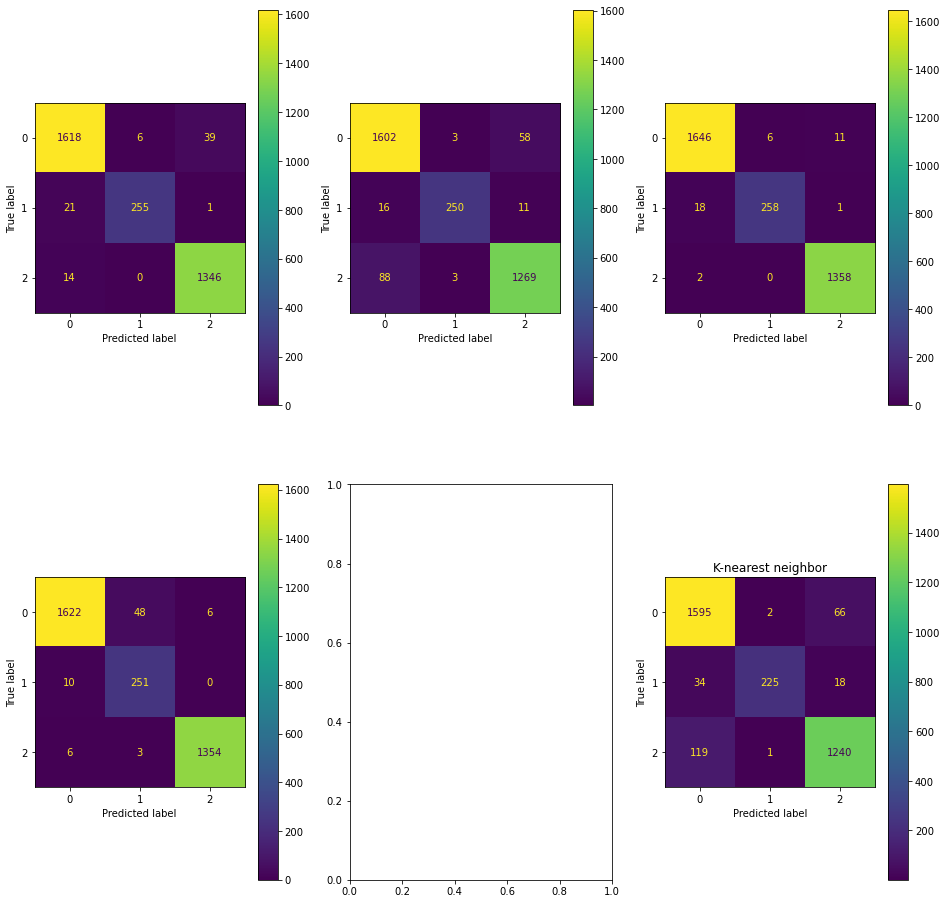

In [27]:
# plot the confusion matrix
import pylab as pl
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(16, 16))
disp=plot_confusion_matrix(clf, X_test, y_test,ax = axes[0][0])
pl.title('Multi-layer perceptron')
plot_confusion_matrix(svc, X_test, y_test,ax = axes[0][1]) 
pl.title('support vector')
plot_confusion_matrix(rfc, X_test, y_test,ax = axes[0][2]) 
pl.title('random forest')
b=plot_confusion_matrix(gnb, X_test_gnb, y_test_gnb,ax = axes[1][0])  
pl.title('Naive Bayes')
a=plot_confusion_matrix(knn, X_test, y_test,ax = axes[1][2]) 
pl.title('K-nearest neighbor')

**Task: Comment on what you see the best classifier is likely to be (1 point).** You can also comment on the misclassification and confusion rates.

### 2.4.a K Fold Cross Validation
We will now perform k fold cross valdiation for the classifiers. We use the function ``cross_val_score`` on each ewstimator, on the training set, with 10 folds, and use accuracy as a score metric.

**Task: perform the cross validation over K folds, output the mean and standard deviation of the accuracy (3 points)**

In [29]:
from sklearn.model_selection import cross_val_score

rfc_cv = RandomForestClassifier(n_estimators=100)
scores_rfc = cross_val_score(rfc_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores_rfc)
print("K-nearest neighbors Mean:", scores_rfc.mean()," Standard Deviation:", scores_rfc.std())


Scores: [0.9880597  0.99253731 0.99402985 0.99850746 0.98955224 0.98955224
 0.99402985 0.99402985 0.99104478 0.99104478]
K-nearest neighbors Mean: 0.9922388059701494  Standard Deviation: 0.002894137228308284


In [30]:
mlp_cv = MLPClassifier(random_state=1)
scores_mlp = cross_val_score(mlp_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores_mlp)
print("K-nearest neighbors Mean:", scores_mlp.mean()," Standard Deviation:", scores_mlp.std())

Scores: [0.97910448 0.96716418 0.98059701 0.9761194  0.96716418 0.97761194
 0.9761194  0.97761194 0.9761194  0.97462687]
K-nearest neighbors Mean: 0.9752238805970149  Standard Deviation: 0.004336071357114614


In [31]:
svc_cv = SVC()
scores_svc = cross_val_score(svc_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores_svc)
print("K-nearest neighbors Mean:", scores_svc.mean()," Standard Deviation:", scores_svc.std())


Scores: [0.95074627 0.93432836 0.94179104 0.94925373 0.94179104 0.92835821
 0.95223881 0.94179104 0.93731343 0.94328358]
K-nearest neighbors Mean: 0.942089552238806  Standard Deviation: 0.007089159454947997


In [32]:
gnb_cv=GaussianNB()
scores_gnb = cross_val_score(gnb_cv, X_train_gnb, y_train_gnb, cv=10, scoring = "accuracy")
print("Scores:", scores_gnb)
print("K-nearest neighbors Mean:", scores_gnb.mean()," Standard Deviation:", scores_gnb.std())


Scores: [0.97761194 0.98507463 0.95970149 0.9761194  0.9761194  0.98208955
 0.97313433 0.97014925 0.98656716 0.9761194 ]
K-nearest neighbors Mean: 0.9762686567164179  Standard Deviation: 0.00735595315244873


In [33]:
knn_cv = KNeighborsClassifier()
scores_knn = cross_val_score(knn_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores_knn)
print("K-nearest neighbors Mean:", scores_knn.mean()," Standard Deviation:", scores_knn.std())


Scores: [0.92537313 0.92686567 0.92686567 0.91791045 0.92835821 0.91492537
 0.93731343 0.92238806 0.91791045 0.92985075]
K-nearest neighbors Mean: 0.9247761194029849  Standard Deviation: 0.006339331516894134


**Task: Which method won the Xval test (1 point) ?**

see the cell below

<!-- answer here -->





### 2.4.c And the winner is ...

Let's compare the results. 
**Task: Create a pandas dataframe with all of the performance metrics, including the results from K-fold cross validation. (2 points)**

In [34]:
# create data frame
results = pd.DataFrame({
    'Model': ['KNN', 'Naive Bayes', 'Random Forest', 'SVC','MLP'],
    'Accuracy': [acc_knn, acc_gnb, acc_rfc, acc_svc, acc_mlp],
    'Precision': [pres_knn, pres_gnb, pres_rfc, pres_svc, pres_mlp],
    'Recall': [rec_knn, rec_gnb, rec_rfc, rec_svc, rec_mlp],
    'Fscore': [f1_knn, f1_gnb, f1_rfc, f1_svc, f1_mlp],
    'Kfold_accuracy_mean': [scores_knn.mean(),scores_gnb.mean(),scores_rfc.mean(),scores_svc.mean(),scores_mlp.mean()],
    'Kfold_accuracy_std': [scores_knn.std(),scores_gnb.std(),scores_rfc.std(),scores_svc.std(),scores_mlp.std()]})
# sort values by the Fscore with the greatest value first.

result_df = results.sort_values(by='Fscore', ascending=False)
result_df = result_df.set_index('Model')
result_df


,Accuracy,Precision,Recall,Fscore,Kfold_accuracy_mean,Kfold_accuracy_std
Model,,,,,,
Random Forest,98.848485,0.988485,0.988485,0.988485,0.992239,0.002894
Naive Bayes,97.787879,0.977879,0.977879,0.977879,0.976269,0.007356
MLP,97.545455,0.975455,0.975455,0.975455,0.975224,0.004336
SVC,94.575758,0.945758,0.945758,0.945758,0.942090,0.007089
KNN,92.727273,0.927273,0.927273,0.927273,0.924776,0.006339


**Task: Comment on the accuracy and performance and choose a winner. (1 point)**

Random Forest seems to be to most accurate among all the classifiers.
Worst is the K-Nearest neighbors

<!-- answer here -->






## 3 Summary (4 points)

### 3.1 Feature Importance using Random Forest Classifier

Decision Trees have the unique property of being able to order features by their ability to split between the classes. If some features dominate over other in the predictive power of classes, one can further reduce the dimension of the features for additional analysis. The vector of feature importance is the module ``rfc.feature_importances_``, sorted with ascending importance. Store the vector of importance .

**Task: plot a bar plot using the function ``matplotlib.pyplot.bar``. (2 points)**

In [38]:
# answer
import numpy as np
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


In [39]:
print(pd.DataFrame(rfc.feature_importances_))


          0
0  0.002574
1  0.002603
2  0.540889
3  0.182275
4  0.018211
5  0.002393
6  0.076862
7  0.097888
8  0.076305


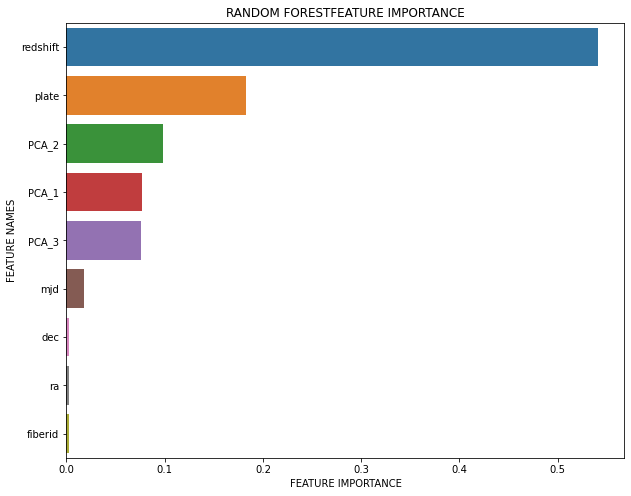

In [40]:
plot_feature_importance(rfc.feature_importances_,['ra', 'dec', 'redshift','plate','mjd','fiberid','PCA_1','PCA_2','PCA_3'],'RANDOM FOREST')

**Task: What are the top three features (1 point)?**

Redshift, plate, PCA2

<!-- answer -->

In this notebook, you have learned that redshift was the best predictor of what object you are observing. Now, did you actualy need to do this all to find this out? Probably not if you were an astrophysicist! But hey, we are not. So great job!

**Task: Briefly comment on what you have learned (1 point)**

I've learned all about how to execute different types of classifiers

<!-- answer -->